In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader as DL
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 32

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [33]:
from generation import FiguresDataset, id_to_cname
from process import show_img, pick, sample

I've found a weird way to transform bounding boxes, labels (some of those may disappear) and images altogether in a same manner

In [22]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
tr_list = [A.Normalize((0, 0, 0), (0.5, 0.5, 0.5)), A.Resize(416, 416), ToTensorV2()]
tr = A.Compose(tr_list, bbox_params=A.BboxParams(format='yolo', label_fields=['cidx'], min_visibility=0.5))

In [23]:
ds = FiguresDataset(transforms=tr)

10000 images, boxes, class indices have been loaded successfully


We've casted our dataset to torch.float tensors scaled to $[0,1]$ and normalized (sub mean div std), and their labels -- two lists containing normalized tuples $(xcenter, ycenter, width, height)$ and int class labels

In [24]:
ds[0][0].dtype, ds[0][0].shape

(torch.float32, torch.Size([3, 416, 416]))

In [25]:
ds[0][1], ds[0][2], ds[0][3][0][2].shape, id_to_cname

([(0.5625, 0.734375, 0.20316117775451398, 0.20316117775451403),
  (0.2265625, 0.3828125, 0.39453125, 0.140625),
  (0.22265625, 0.734375, 0.3712596422839135, 0.4381427535463591),
  (0.83984375, 0.37890625, 0.13151385455243214, 0.13151385455243214)],
 [4, 3, 2, 0],
 torch.Size([3, 52, 52, 6]),
 ['Circle', 'Rhombus', 'Rectangle', 'Triangle', 'Hexagon'])

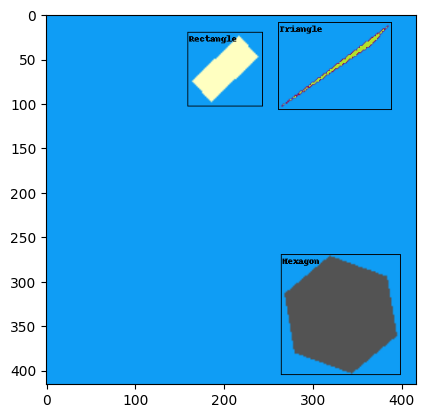

(None, [4, 2, 3])

In [26]:
show_img(pick(ds[666][:3])), ds[666][2]

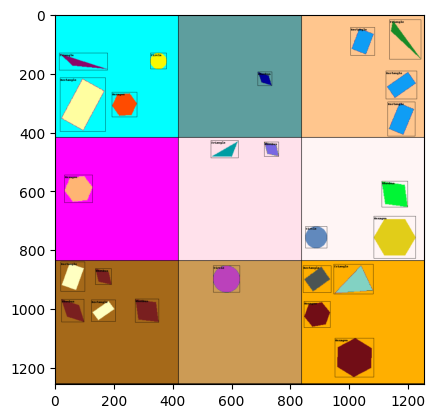

In [27]:
sample(ds)

YOLO is an agorithm that processes whole image in 1-pass manner using just convolutions

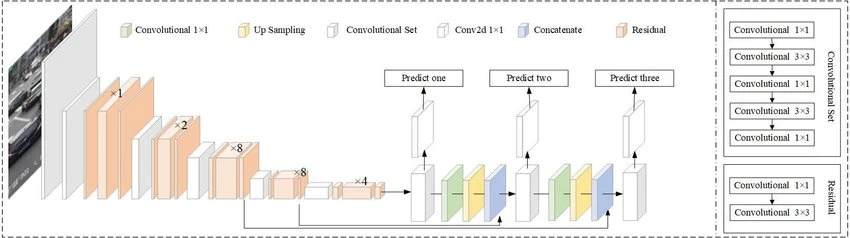

Our feature extractor (feature encoder) is somewhat typical, i.e. we stick to convolutional layers only, so that is FCN (but with bells and whistles), it outputs some feature map

But the classifier/regressor (feature decoder) is 1x1 convolution over feature map, result is called cell map (same size) 
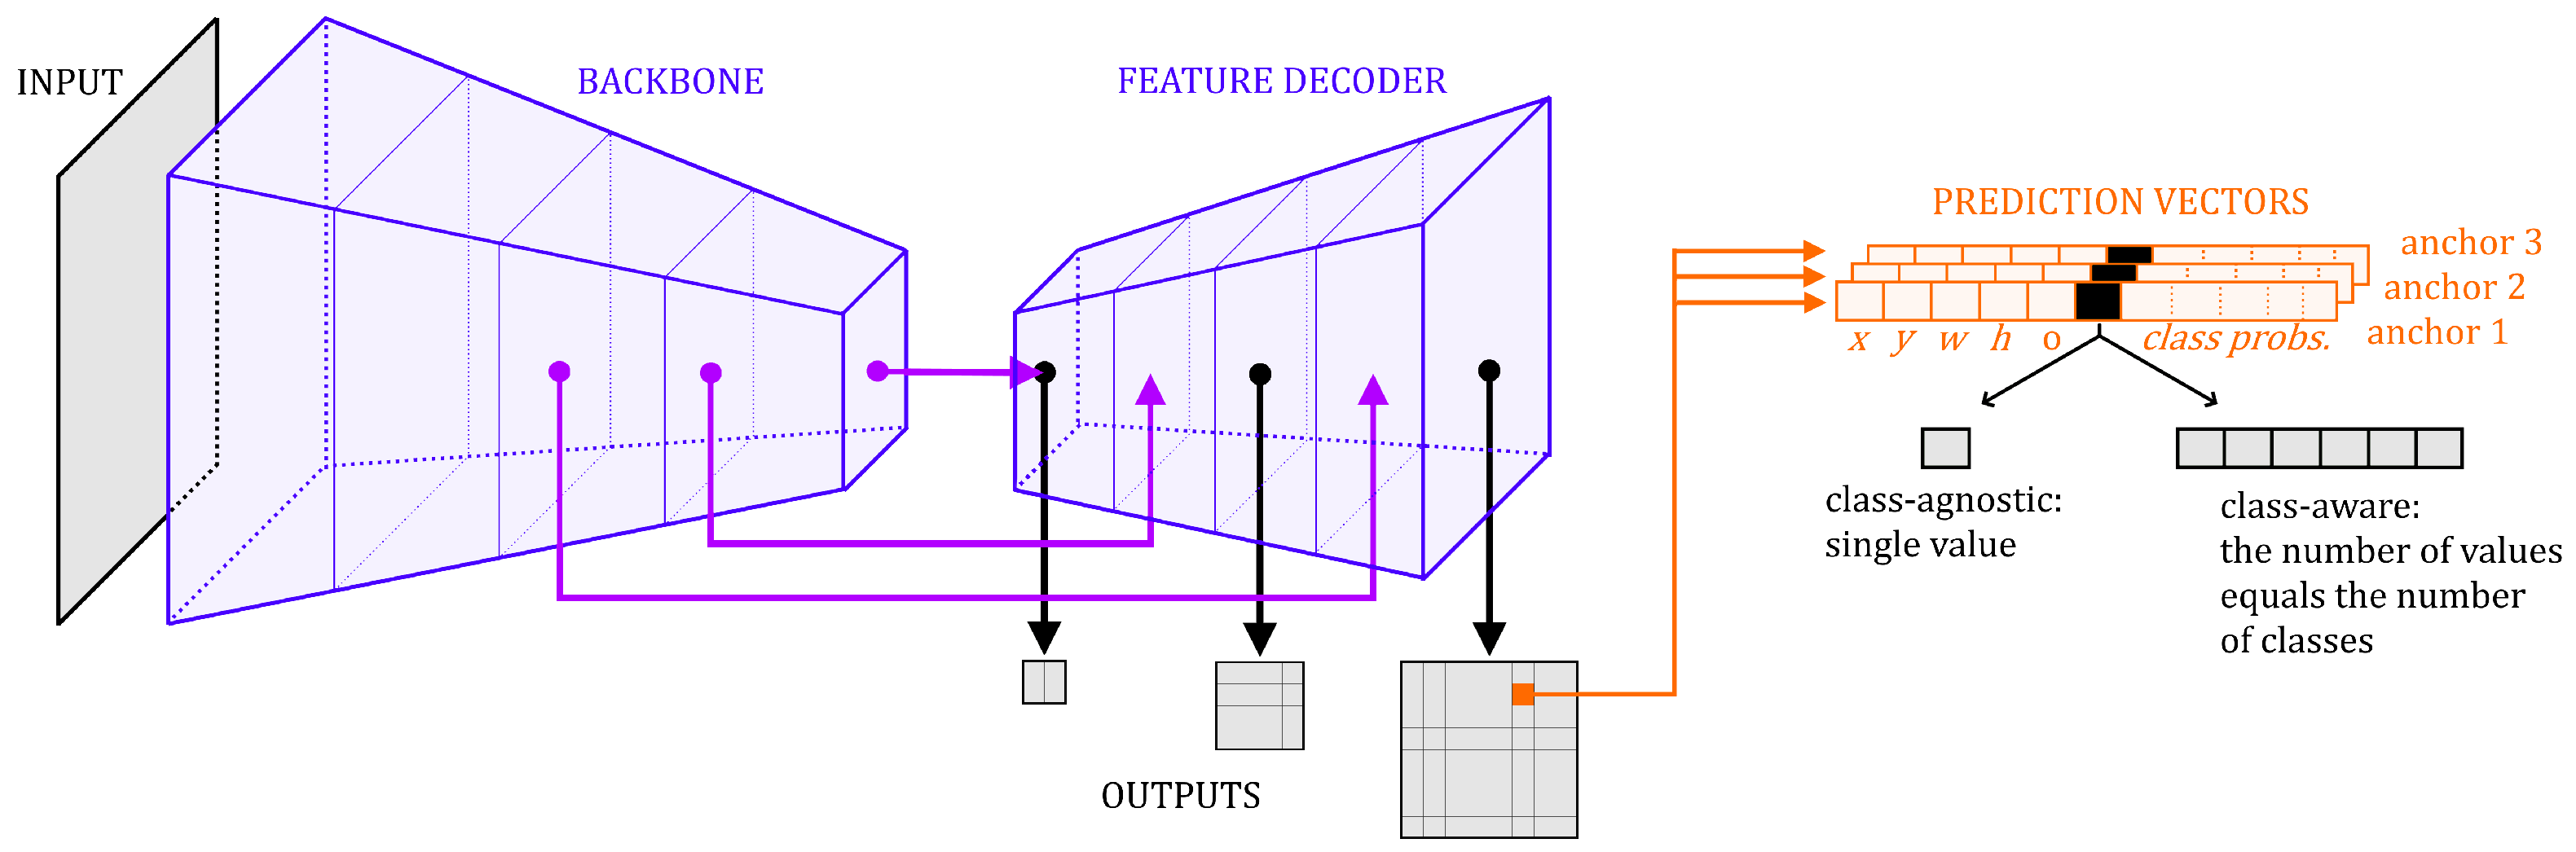

Each cell has to predict ONE object (=one of its bboxes) if its center falls into receiptive field

## Anchors concept (for YOLO)

Suppose that a cell can predict a fixed amount of bounding boxes (B=3 for v3) and each of those tends to 'specialize' in detecting particular type(proportion, scale) of object (vertical human, horizontal car, square...)
We don't want to output directly xywh boxes(unstable gradients), instead we switch to relative coordinates and pre-define 3 boxes $[pw, ph]$ attached to each cell $tlc=[cx,cy]$ aka 'anchors'

Our network controls 'offset' parameters $[tx, ty, tw, th]$ for (log-space) transformation: (some) Anchor $\Longrightarrow$  Ground Truth BBox
\begin{split}
\frac{BB_x}{W} = cx + \sigma(tx) \Longleftrightarrow x_r = cx + \sigma(tx)\\
\frac{BB_y}{H} = cy + \sigma(ty) \Longleftrightarrow y_r = cy + \sigma(tx)\\
\frac{BB_w}{W} = \frac{P_w}{W}*e^{tw} \Longleftrightarrow w_r =pw*e^{tw}\\
\frac{BB_h}{H} = \frac{P_h}{H}*e^{th} \Longleftrightarrow h_r =ph*e^{th}
\end{split}

Note that all target (center, wh) bbox and anchors' (wh) coordinates aren't absolute pixel values, they're relative to image size (= 416), that's how we construct a dataset

Anchors are given before training, represent some prior knowledge about this dataset (typical object scale and aspect ratio). They are generated using k-means clustering algorithm on all bboxes before training. Should be customized as our dataset is by no means similar to COCO)

In [28]:
ds.anchors, ds.grid_sizes

((((0.28, 0.22), (0.38, 0.48), (0.9, 0.78)),
  ((0.07, 0.15), (0.15, 0.11), (0.14, 0.29)),
  ((0.02, 0.03), (0.04, 0.07), (0.08, 0.06))),
 (13, 26, 52))

In [29]:
ds[0][1] # ground truth bboxes for element #0

[(0.5625, 0.734375, 0.20316117775451398, 0.20316117775451403),
 (0.2265625, 0.3828125, 0.39453125, 0.140625),
 (0.22265625, 0.734375, 0.3712596422839135, 0.4381427535463591),
 (0.83984375, 0.37890625, 0.13151385455243214, 0.13151385455243214)]

How to train:
let's create an S-grid on original image and match 1:1 to the cells from output
$$inp.cells \Leftrightarrow out.cells$$
Say, ic contains center of ob"ject's bbox, then corresponding oc is responsible for its detection

So, we choose an anchor with a highest IoU (with gt box), then tune up its parameters to get a better fit

In [30]:
# each target sets up like ds[element][output_type=3][figure][#scale] = tensor (#anchor * scale_size * scale_size * values)
ds[0][3][0][2].shape

torch.Size([3, 52, 52, 6])

In [31]:
# let's check if any non zero elements
ds[0][3][0][2].count_nonzero().item(), ds[0][3][0][2][ds[0][3][0][2].nonzero(as_tuple=True)]

(6, tensor([ 1.0000,  0.2500,  0.1875, 10.5644, 10.5644,  4.0000]))

In [45]:
loader = DL(dataset=ds, batch_size=1, shuffle=True)
# next(iter(loader))